In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import doctest
import copy

In [2]:
#https://stackoverflow.com/questions/40137950/possible-to-run-python-doctest-on-a-jupyter-cell-function
def test(func):
    '''
    Use test as a decorator to a function with doctests in Jupyter notebook. 
    Run the cell to see the results of the doctests.
    '''
    globs = copy.copy(globals())
    globs.update({func.__name__:func})
    doctest.run_docstring_examples(func, globs, verbose=True, name=func.__name__)
    return func

### Simulate straight line and circular movements with Unicycle model

Robot is at the origin (0, 0) and facing North, i.e, $\theta = \pi/2$

Use the Kinematics equations we had developed in class for the Unicycle model in coding 

In [4]:
#uncomment this decorator to test your code
@test 
def unicycle_model(curr_pose, v, w, dt=1.0):
    '''
    >>> unicycle_model((0.0,0.0,0.0), 1.0, 0.0)
    (1.0, 0.0, 0.0)
    >>> unicycle_model((0.0,0.0,0.0), 0.0, 1.0)
    (0.0, 0.0, 1.0)
    >>> unicycle_model((0.0, 0.0, 0.0), 1.0, 1.0)
    (1.0, 0.0, 1.0)
    '''
    ## write code to calculate next_pose
    # refer to the kinematic equations of a unicycle model
    x, y, theta = curr_pose
    x += v*np.cos(theta)*dt
    y += v*np.sin(theta)*dt
    theta += w*dt
    
    # Keep theta bounded between [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))
    # return calculated (x, y, theta)
    return x,y,theta

Finding tests in unicycle_model
Trying:
    unicycle_model((0.0,0.0,0.0), 1.0, 0.0)
Expecting:
    (1.0, 0.0, 0.0)
ok
Trying:
    unicycle_model((0.0,0.0,0.0), 0.0, 1.0)
Expecting:
    (0.0, 0.0, 1.0)
ok
Trying:
    unicycle_model((0.0, 0.0, 0.0), 1.0, 1.0)
Expecting:
    (1.0, 0.0, 1.0)
ok


Now let us try to simulate motion along a straight line and circle

Look at the kinematics equations you wrote - what should $v,\omega$ if
+ There is no change in $\theta$
+ $\theta$ has to change from 0 to 360 degrees

In [5]:
#straight line
straight_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
#fill in v and omega values
all_v = np.ones(steps)
all_w = np.zeros(steps)
for v,w in zip(all_v,all_w):
   #store pose
   straight_trajectory.append(pose) 
   #compute new pose
   pose = unicycle_model(pose, v, w)
straight_trajectory = np.array(straight_trajectory)

In [6]:
straight_trajectory

array([[0.00000000e+00, 0.00000000e+00, 1.57079633e+00],
       [6.12323400e-17, 1.00000000e+00, 1.57079633e+00],
       [1.22464680e-16, 2.00000000e+00, 1.57079633e+00],
       [1.83697020e-16, 3.00000000e+00, 1.57079633e+00],
       [2.44929360e-16, 4.00000000e+00, 1.57079633e+00],
       [3.06161700e-16, 5.00000000e+00, 1.57079633e+00],
       [3.67394040e-16, 6.00000000e+00, 1.57079633e+00],
       [4.28626380e-16, 7.00000000e+00, 1.57079633e+00],
       [4.89858720e-16, 8.00000000e+00, 1.57079633e+00],
       [5.51091060e-16, 9.00000000e+00, 1.57079633e+00]])

In [7]:
#circle
circle_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
#fill in v and omega values
#v = r*w
all_v = np.ones(steps*100)
all_w = np.ones(steps*100)
for v,w in zip(all_v , all_w):
   #store pose
   circle_trajectory.append(pose)
   #compute new pose
   pose = unicycle_model(pose,v,w,0.1)
circle_trajectory = np.array(circle_trajectory)


In [8]:
circle_trajectory

array([[ 0.00000000e+00,  0.00000000e+00,  1.57079633e+00],
       [ 6.12323400e-18,  1.00000000e-01,  1.67079633e+00],
       [-9.98334166e-03,  1.99500417e-01,  1.77079633e+00],
       ...,
       [-3.62494130e-01, -7.21674808e-01,  7.39831412e-01],
       [-2.88635908e-01, -6.54258467e-01,  8.39831412e-01],
       [-2.21877072e-01, -5.79805409e-01,  9.39831412e-01]])

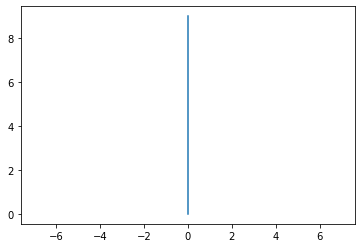

In [9]:
### Plotting straight trajectories
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(straight_trajectory[:,0],straight_trajectory[:,1])


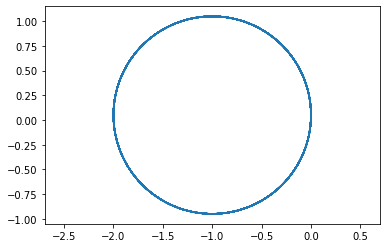

In [10]:
### Plotting circle trajectories
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(circle_trajectory[:,0],circle_trajectory[:,1])

### Simulate Unicycle model with Open Loop control

We want the robot to follow these instructions

**straight 10m, right turn, straight 5m, left turn, straight 8m, right turn**

It is in open loop; control commands have to be calculated upfront. How do we do it?

To keep things simple in the first iteration, we can fix $v = v_c$ and change only $\omega$. To make it even simpler, $\omega$ can take only 2 values 
+ 0 when the vehicle is going straight 
+ $\omega = \omega_c$ when turning

This leaves only 2 questions to be answered
* What should be $v_c$ and $\omega_c$?
* When should $\omega$ change from 0 and back?

In [12]:
vc = 1 #m/s
wc = np.pi/6 #rad/s

#calculate time taken to finish a quarter turn (pi/2)
t_turn = int(np.pi/2/wc)

#calculate the time taken to finish straight segments - 3 secs
# omega array is to be padded with equivalent zeros

t_straight1, t_straight2, t_straight3 = int(10/vc) , int(5/vc) , int(8/vc)

all_w = [0]*t_straight1 + [wc]*t_turn + \
        [0]*t_straight2 + [wc]*t_turn + \
        [0]*t_straight3 + [-wc]*t_turn

all_v = vc*np.ones_like(all_w)

Let us make a cool function out of this!

Take in as input a generic route and convert it into open-loop commands

Input format: [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]

Output: all_v, all_w

In [108]:
def get_open_loop_commands(route, dt = 1.0 ,vc_slow = 0.5, vc_fast = 1, wc = np.pi/12 ):
    all_w = []
    omegas = {'straight':0, 'left':wc, 'right':-wc}
    for manoeuvre, command in route:
      t_cmd = np.ceil(command/vc).astype('int') if manoeuvre == 'straight' else np.ceil(np.deg2rad(command)/wc).astype('int')
      all_w += [omegas[manoeuvre]]*t_cmd
    all_v = np.ones_like(all_w)
    for i in all_w:
      all_v[i] = vc_fast if all_w[i] == 0 else vc_slow
    return all_v, all_w

### Unit test your function with the following inputs

+ [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]
+ $v_c = 1$
+ $w_c = \pi/12$

In [70]:
all_v, all_w = get_open_loop_commands([("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]) 

In [99]:
robot_trajectory = []
pose = (0, 0, np.pi/2)
all_v, all_w = get_open_loop_commands([("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]) 
t = dt
pose = np.array([0, 0, np.pi/2])
for v, w in zip(all_v, all_w):
    #store pose
    robot_trajectory.append(pose)
    #instruction to take v, w and compute new pose    
    pose = unicycle_model(pose,v/t,w/t,t)
robot_trajectory = np.array(robot_trajectory)

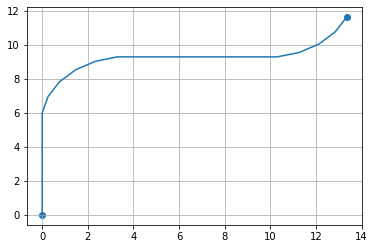

In [111]:
# plot robot trajectory
plt.figure()
plt.grid()
#plt.plot( )

#show first and last robot positions with + markers
xi,yi, thetai = robot_trajectory[0]
xf,yf, thetaf = robot_trajectory[-1]
plt.plot(robot_trajectory[:,0],robot_trajectory[:,1])
plt.scatter([xi,xf],[yi,yf])
# example: plt.plot(0, 0, 'r+', ms=10)


### Improved capabilities!

+ Slow the robot while turning ($v_c$ for turn and straight needed)

+ How to accommodate a sampling time < 1.0s (hint: think of sampling instances instead of time)

### Improved capabilities added in the above functions itself

